# Process 1B

![Process 1 Diagram](images/process-1.png)

In [1]:
### Imports
import pandas as pd
import numpy as np

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Read Data

In [2]:
### Read in data
path = "https://github.com/car13mesquita/DATA6545-Competition-1/raw/main/Competition1_raw_data.xlsx"
df = pd.read_excel(path, na_values=["-"])

# Filter Desired Features

In [3]:
### Copy dataframe
df1 = df.iloc[:, 2:]

# Validate Data

In [4]:
def validate_data(col, test):
    if test == "non-negative":
        return np.where(col >= 0, col, np.nan)
    elif test == "positive":
        return np.where(col > 0, col, np.nan)
    elif test == "binary":
        return np.where((col == 0) | (col == 1), col, np.nan)

### Add columns to check to each of the lists
### C3 & C4 must be a number
### P(IPO), P(H), P(L), P(1Day) causing errors
check_binary = ['C2']
check_non_negative = ['C7']
check_positive = ['C1', 'C5', 'C6', 'T1', 'T2', 'T3', 'T4', 'T5', 'S1', 'S2', 'S3']

### Run non-negative check on columns
for col in check_non_negative:
    df1[col] = df1[col].apply(validate_data, test="non-negative")
### Run positive check on columns
for col in check_positive:
    df1[col] = df1[col].apply(validate_data, test="positive")
## run binary check on columns
for col in check_binary:
    df1[col] = df1[col].apply(validate_data, test="binary")

df2 = df1.copy()

# Fix Missing

In [5]:
print("Shape Before:", df2.shape)
df2.isna().mean() * 100

Shape Before: (682, 20)


I3          1.173021
P(IPO)      0.733138
P(H)        1.466276
P(L)        1.466276
P(1Day)     3.225806
C1          3.225806
C2          3.225806
C3          5.278592
C4          3.225806
C5          0.879765
C6          0.879765
C7         10.557185
T1          0.146628
T2          0.439883
T3          0.586510
T4          0.439883
T5          0.293255
S1          0.293255
S2          0.146628
S3          0.146628
dtype: float64

In [6]:
def fix_missing(df):
    df = df.dropna(subset=['P(IPO)', 'P(H)', 'P(L)', 'P(1Day)']).reset_index(drop=True)

    df_cat = df.iloc[:, :1]
    df_cont = df.iloc[: , 1:]

    inames = list(df_cont.columns)
    imp_med = SimpleImputer(missing_values=np.nan, strategy='median')
    df_cont = pd.DataFrame(imp_med.fit_transform(df_cont), columns=inames)

    df = pd.concat([df_cat, df_cont], axis=1)
    return df

df2 = fix_missing(df2)

In [7]:
print("Shape After:", df2.shape)
df2.isna().mean() * 100

Shape After: (660, 20)


I3         0.0
P(IPO)     0.0
P(H)       0.0
P(L)       0.0
P(1Day)    0.0
C1         0.0
C2         0.0
C3         0.0
C4         0.0
C5         0.0
C6         0.0
C7         0.0
T1         0.0
T2         0.0
T3         0.0
T4         0.0
T5         0.0
S1         0.0
S2         0.0
S3         0.0
dtype: float64

# Create Features

In [8]:
def create_features(df):
    ### P(mid)
    df['P(mid)'] = (df['P(H)'] + df['P(L)']) / 2

    ### Pre-IPO Price Revision
    df['Y1'] = np.where(df['P(IPO)'] < df['P(mid)'], 1, 0) 

    ### Post-IPO initial Return
    df['Y2'] = np.where(df['P(IPO)'] < df['P(1Day)'], 1, 0) 

    ### Positive EPS Dummy
    df["eps_dummy"] = np.where(df['C3'] > 0, 1, 0)

    ### Share Overhang
    df["overhang"] = df['C5'] / df['C6']

    ### Up revision
    df["up_revision"] = np.where(df['P(IPO)'] > df['P(mid)'], ((df['P(IPO)'] - df['P(mid)']) / df['P(mid)']) * 100 , 0)

    ### Ratio of long sentences out of total sentences
    df["long_s/total_s"] = (df['T4']/ df['T1'])

    ### Ratio of real words out of total words 
    df["real_w/total_w"] = (df['T3']/ df['T2'])

    ### Ratio of long words out of real words
    df["long_w/real_w"] = (df['T5']/ df['T3'])

    ### Ratio of positive words out of real words
    df["positive_w/real_w"] = (df['S1']/ df['T3'])

    ### Ratio of negative words out of real words
    df["negative_w/real_w"] = (df['S2']/ df['T3'])

    ### Ratio of uncertain words out of real words
    df["uncertain_w/real_w"] = (df['S3']/ df['T3'])

    return df

df3 = create_features(df2)
df3.dtypes

I3                     object
P(IPO)                float64
P(H)                  float64
P(L)                  float64
P(1Day)               float64
C1                    float64
C2                    float64
C3                    float64
C4                    float64
C5                    float64
C6                    float64
C7                    float64
T1                    float64
T2                    float64
T3                    float64
T4                    float64
T5                    float64
S1                    float64
S2                    float64
S3                    float64
P(mid)                float64
Y1                      int64
Y2                      int64
eps_dummy               int64
overhang              float64
up_revision           float64
long_s/total_s        float64
real_w/total_w        float64
long_w/real_w         float64
positive_w/real_w     float64
negative_w/real_w     float64
uncertain_w/real_w    float64
dtype: object

In [9]:
def bin_tech_nontech (col):
    ### Create a mask that checks if the first two characters of the value in the 'I3' column are equal to 73
    mask_73 = col.astype(str).str[:2] == "73"

    ### Create a mask that checks if the first two characters of the value in the 'I3' column are equal to 37
    mask_37 = col.astype(str).str[:2] == '37'

    ### Create a mask that checks if the first four characters of the value in the 'I3' column are equal to 3674
    mask_semiconductors = col.astype(str).str[:4] == '3674'

    ###This is creating a mask that checks if the first 3 nummbers are 506
    electrical_goods = col.astype(str).str[:3] == '506'

    ###This is creating a mask that checks if the first 4 nummbers are 3572
    comp_storage = col.astype(str).str[:4] == '3572'

    ### np.logicalor statement is just seeing if any are true and had to use a few because it only takes 3 argumenrs
    mask_tech = np.logical_or(mask_73, np.logical_or(mask_37, np.logical_or(mask_semiconductors, np.logical_or(electrical_goods, comp_storage))))
    ### Then we just put it into a quick np.where and this creates a tech/non-tech bin
    col = np.where(mask_tech, 1, 0)

    return col

df3['sic_tech-non_tech'] = bin_tech_nontech(df3['I3'])
df3.dtypes

I3                     object
P(IPO)                float64
P(H)                  float64
P(L)                  float64
P(1Day)               float64
C1                    float64
C2                    float64
C3                    float64
C4                    float64
C5                    float64
C6                    float64
C7                    float64
T1                    float64
T2                    float64
T3                    float64
T4                    float64
T5                    float64
S1                    float64
S2                    float64
S3                    float64
P(mid)                float64
Y1                      int64
Y2                      int64
eps_dummy               int64
overhang              float64
up_revision           float64
long_s/total_s        float64
real_w/total_w        float64
long_w/real_w         float64
positive_w/real_w     float64
negative_w/real_w     float64
uncertain_w/real_w    float64
sic_tech-non_tech       int64
dtype: obj

In [10]:
def classify(code):
    if code >= 20 and code <= 39:
        return 'mfg'
    elif code >= 70 and code <= 89:
        return 'svc'
    else:
        return 'other'

def bin_mso(row):
    row = str(row)
    if len(row.split(", ")) == 1:
        pre = int(row[:2])
        code = classify(pre)
        return code
        ### Add logic here to count how many of each code there are
        ### use classify helper function
    else:
        return row

df3['sic_mso'] = df3['I3'].apply(bin_mso)

### Manual fixes for multiple SIC Codes
df3.loc[df3['sic_mso'] == '6794, 3861, 3663, 7819', 'sic_mso'] = 'svc'
df3.loc[df3['sic_mso'] == '3651, 6794, 7819', 'sic_mso'] = 'svc'
df3.loc[df3['sic_mso'] == '3663, 3861, 6794', 'sic_mso'] = 'other'
df3.loc[df3['sic_mso'] == '7389, 5063', 'sic_mso'] = 'mfg'

### OHE
dummy_df = pd.get_dummies(df3['sic_mso'], prefix='sic')
df3 = pd.concat([df3, dummy_df], axis=1)

In [11]:
df4 = df3.loc[:, ('up_revision', 'C1', 'C4', 'overhang', 'C7', 
                  'long_s/total_s', 'real_w/total_w', 'long_w/real_w', 
                  'positive_w/real_w', 'negative_w/real_w', 'uncertain_w/real_w',
                  'C2', "eps_dummy", "sic_tech-non_tech", 
                  'sic_mfg', 'sic_svc', 'sic_other',
                  'Y1', 'Y2')]
df4.dtypes

up_revision           float64
C1                    float64
C4                    float64
overhang              float64
C7                    float64
long_s/total_s        float64
real_w/total_w        float64
long_w/real_w         float64
positive_w/real_w     float64
negative_w/real_w     float64
uncertain_w/real_w    float64
C2                    float64
eps_dummy               int64
sic_tech-non_tech       int64
sic_mfg                 uint8
sic_svc                 uint8
sic_other               uint8
Y1                      int64
Y2                      int64
dtype: object

# EDA

In [12]:
### Continuous Features
df_cont = df4.iloc[:, :11]
print(df_cont.columns)

### Categorical Features
df_cat = df4.iloc[: , 11:]
print(df_cat.columns)

Index(['up_revision', 'C1', 'C4', 'overhang', 'C7', 'long_s/total_s',
       'real_w/total_w', 'long_w/real_w', 'positive_w/real_w',
       'negative_w/real_w', 'uncertain_w/real_w'],
      dtype='object')
Index(['C2', 'eps_dummy', 'sic_tech-non_tech', 'sic_mfg', 'sic_svc',
       'sic_other', 'Y1', 'Y2'],
      dtype='object')


In [13]:
df_cont.describe()

,up_revision,C1,C4,overhang,C7,long_s/total_s,real_w/total_w,long_w/real_w,positive_w/real_w,negative_w/real_w,uncertain_w/real_w
count,660.000000,660.000000,660.000000,660.000000,660.000000,660.000000,660.000000,660.000000,660.000000,660.000000,660.000000
mean,5.404645,149.728788,0.007282,4.417255,470.631368,0.628496,0.895157,0.058355,0.005940,0.010118,0.012855
std,10.877569,152.817467,0.033318,5.133537,1587.801852,0.069606,0.044090,0.007148,0.001928,0.003310,0.003074
min,0.000000,10.000000,-0.162352,0.283223,0.074000,0.395480,0.669838,0.035738,0.001896,0.002454,0.006215
25%,0.000000,85.000000,-0.013927,2.850622,41.458000,0.580706,0.883417,0.053662,0.004608,0.007843,0.010724
50%,0.000000,107.000000,0.009125,3.731035,107.462000,0.628861,0.897294,0.058163,0.005641,0.009549,0.012639
75%,7.692308,155.250000,0.031571,4.857904,300.764000,0.674461,0.909693,0.062670,0.006984,0.011805,0.014270
max,100.000000,2087.000000,0.092896,99.787255,30683.000000,0.826347,1.579238,0.082675,0.014453,0.028048,0.033235


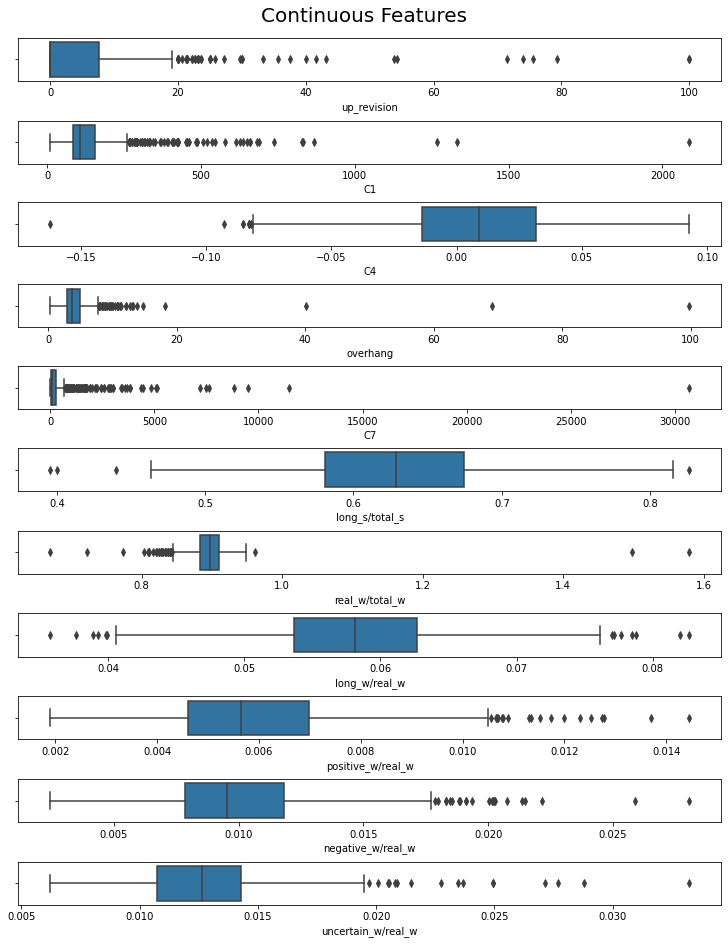

In [14]:
def eda_cont(df):
    cols = list(df.columns)
    fig, axes = plt.subplots(len(cols), 1, figsize=(10, 13), constrained_layout=True)

    for ax, feat in enumerate(cols):
        sns.boxplot(data=df, x=feat, ax=axes[ax])

    fig.suptitle("Continuous Features", fontsize=20)
    plt.show()

eda_cont(df_cont)

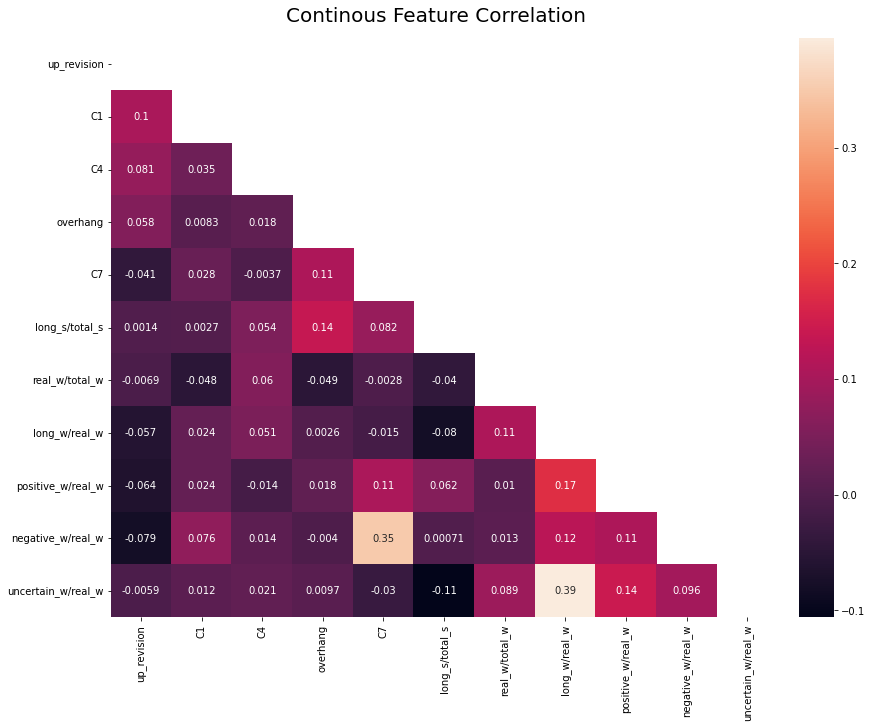

In [15]:
def heatmap(df):
    fig, axes = plt.subplots(figsize=(12,10), constrained_layout=True)

    mask = np.triu(np.ones_like(df.corr(), dtype=bool))

    sns.heatmap(data=df.corr(), mask=mask, annot=True, ax=axes)

    fig.suptitle("Continous Feature Correlation", fontsize=20)
    plt.show()

heatmap(df_cont)

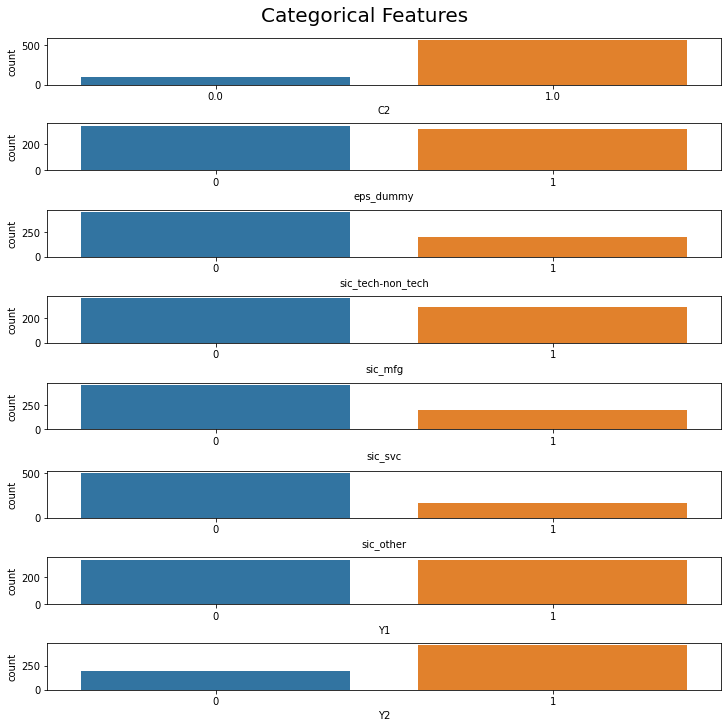

In [16]:
def eda_cat(df):
    cols = list(df.columns)
    fig, axes = plt.subplots(len(cols), 1, figsize=(10,10), constrained_layout=True)

    for ax, feat in enumerate(cols):
        sns.countplot(x=feat, data=df, ax=axes[ax])

    fig.suptitle("Categorical Features", fontsize=20)
    plt.show()

eda_cat(df_cat)

# Transformations

## Normalization (yeo-johnson)

In [17]:
df_cont2 = df_cont.copy()

In [18]:
df_cont2.skew()

up_revision            4.372685
C1                     5.649485
C4                    -0.477892
overhang              13.405536
C7                    12.163784
long_s/total_s        -0.073343
real_w/total_w         9.101177
long_w/real_w          0.143321
positive_w/real_w      0.942716
negative_w/real_w      1.215448
uncertain_w/real_w     1.495513
dtype: float64

In [19]:
def normalize(df):
    df_skew = df.loc[:, (df.skew() < -.5) | (df.skew() > .5)]
    names = list(df_skew.columns)
    pt = PowerTransformer()
    df_skew = pd.DataFrame(pt.fit_transform(df_skew), columns=names)
    df[names] = df_skew[names]
    return df

df_cont2 = normalize(df_cont2)
df_cont2.skew()

up_revision           0.528925
C1                   -0.026719
C4                   -0.477892
overhang             -0.163289
C7                    0.007638
long_s/total_s       -0.073343
real_w/total_w       -1.277638
long_w/real_w         0.143321
positive_w/real_w     0.014123
negative_w/real_w     0.029134
uncertain_w/real_w   -0.034104
dtype: float64

In [20]:
df_cont2.insert(0, 'up_revision_log_plus1', np.log(df_cont2['up_revision'] + 1))
df_cont2.drop(['up_revision'], axis=1, inplace=True)
df_cont2.skew()

up_revision_log_plus1    0.488875
C1                      -0.026719
C4                      -0.477892
overhang                -0.163289
C7                       0.007638
long_s/total_s          -0.073343
real_w/total_w          -1.277638
long_w/real_w            0.143321
positive_w/real_w        0.014123
negative_w/real_w        0.029134
uncertain_w/real_w      -0.034104
dtype: float64

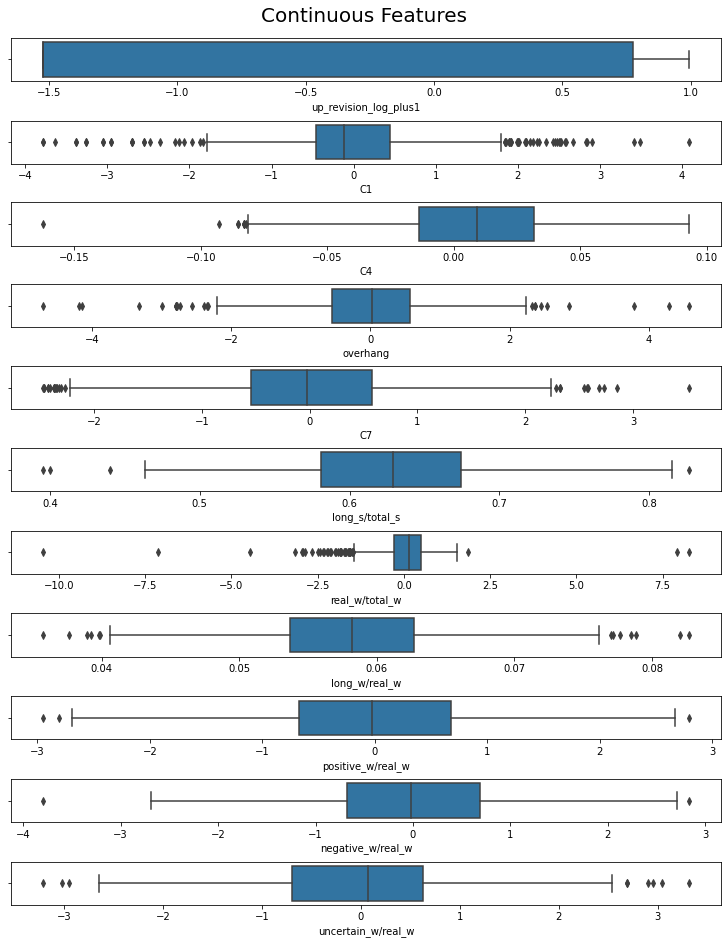

In [21]:
eda_cont(df_cont2)

## Scaling Z-Score

In [22]:
def scale(df, method):
    names = list(df.columns)
    
    if method == 'z':
        scaler = StandardScaler()
    
    elif method == 'min-max':
        scaler = MinMaxScaler()
    
    df = pd.DataFrame(scaler.fit_transform(df), columns=names)

    return df

df_cont2 = scale(df_cont2, 'z')

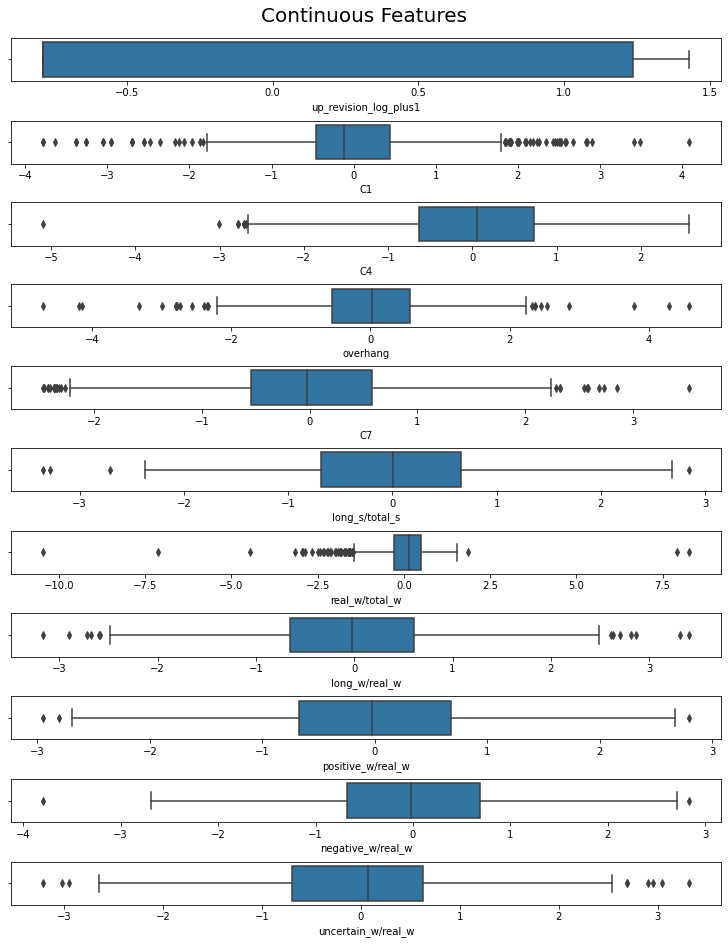

In [23]:
eda_cont(df_cont2)

## Outlier Handling (x_bar +/- 3*std)

In [24]:
def adjust_outliers(col1:pd.Series, method:str):
    '''
    Adjust for outliers in a series using interquartile range or 3 standard deviations
    ---
    ARGUMENTS:
    - col (Series): column from dataframe
    - method (str): adjust by interquartile range or 3 standard deviations
    ---
    OUTPUT:
    - col (Series): column with outliers adjusted for
    '''
    col = col1.copy()
    
    if method == "IQR":
        ### Calculate interquartile range
        q1 =  np.quantile(col, 0.25)
        q3 =  np.quantile(col, 0.75)
        iqr = q3-q1

        ### Use interquartile range to calculate lower and upper bounds
        low_bound = q1 - 1.5 * iqr
        up_bound = q3 + 1.5 * iqr
    
    elif method == "3std":
        ### Get bounds using 3 standard deviation
        low_bound = col.mean() - 3 * col.std()
        up_bound = col.mean() + 3 * col.std()
    
    else:
        return "error"

    ### Replace any low outliers with the lower bound and any high outliers with the upper bound
    col[col < low_bound] = low_bound
    col[col > up_bound] = up_bound

    return col

df_cont2 = df_cont2.apply(adjust_outliers, method="3std")
df_cont2.describe()

,up_revision_log_plus1,C1,C4,overhang,C7,long_s/total_s,real_w/total_w,long_w/real_w,positive_w/real_w,negative_w/real_w,uncertain_w/real_w
count,6.600000e+02,660.000000,660.000000,660.000000,660.000000,660.000000,660.000000,660.000000,6.600000e+02,660.000000,660.000000
mean,4.575465e-17,0.002406,0.003181,0.001057,-0.000783,0.000956,0.004589,-0.000833,8.074349e-18,0.001204,-0.000180
std,1.000758e+00,0.972410,0.987791,0.955524,0.998199,0.997729,0.771896,0.996536,1.000758e+00,0.996653,0.997937
min,-7.874057e-01,-3.002275,-3.002275,-3.002275,-2.474993,-3.002275,-3.002275,-3.002275,-2.950865e+00,-3.002275,-3.002275
25%,-7.874057e-01,-0.463278,-0.637059,-0.558647,-0.549299,-0.687086,-0.284569,-0.657056,-6.720351e-01,-0.681482,-0.700534
50%,-7.874057e-01,-0.115216,0.055340,0.020502,-0.020733,0.005254,0.137494,-0.026883,-2.336440e-02,-0.017884,0.072118
75%,1.235604e+00,0.441142,0.729552,0.569074,0.574346,0.660860,0.497408,0.604102,6.812496e-01,0.691700,0.624427
max,1.427203e+00,3.002275,2.571566,3.002275,3.002275,2.844593,3.002275,3.002275,2.795182e+00,2.831398,3.002275


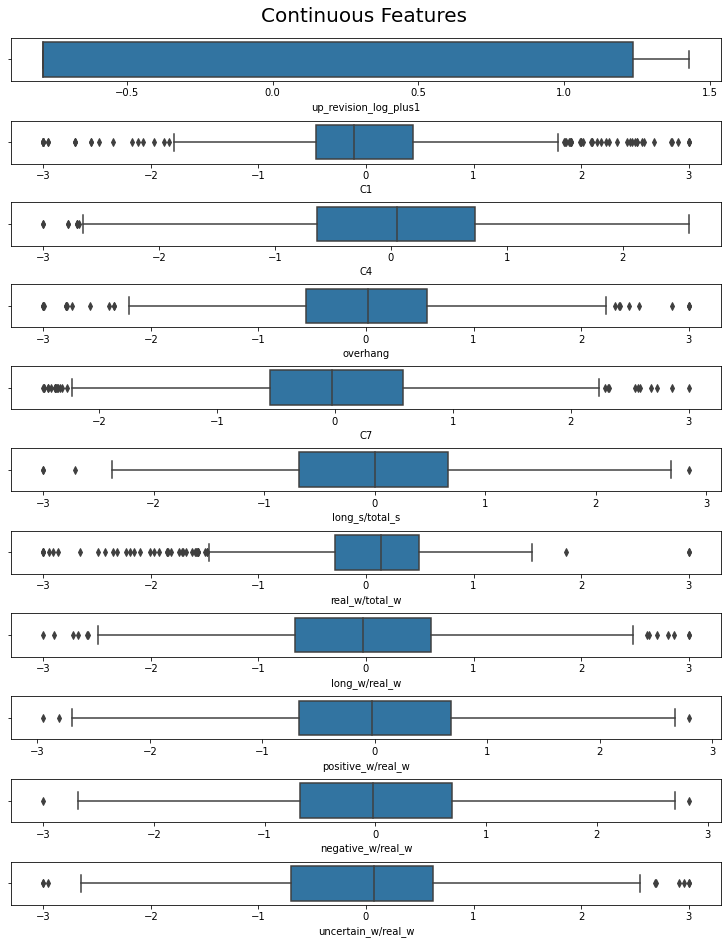

In [25]:
eda_cont(df_cont2)

# Save Data

In [26]:
df5 = pd.concat([df_cont2, df_cat], axis=1).reset_index(drop=True)

In [27]:
process = "1B"
out_path = '/content/drive/MyDrive/Classroom/DATA 6545: Data Science and MLOps SP2023/Competition 1/Shared/carlos/data/process-{}.csv'.format(process)
df5.to_csv(out_path, index=False)